In [1]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import tflearn, psutil, gc
from IPython.display import Image
%matplotlib inline

In [2]:
from rlx.utils import humanbytes
print "free mem", humanbytes(psutil.virtual_memory().free)

free mem 1.04 GB


## Convolutional neural networks

see https://cloud.google.com/blog/big-data/2017/01/learn-tensorflow-and-deep-learning-without-a-phd

see [filter activation demo](http://ml4a.github.io/demos/convolution_all/) [confusion matrix](http://ml4a.github.io/demos/confusion_cifar/)



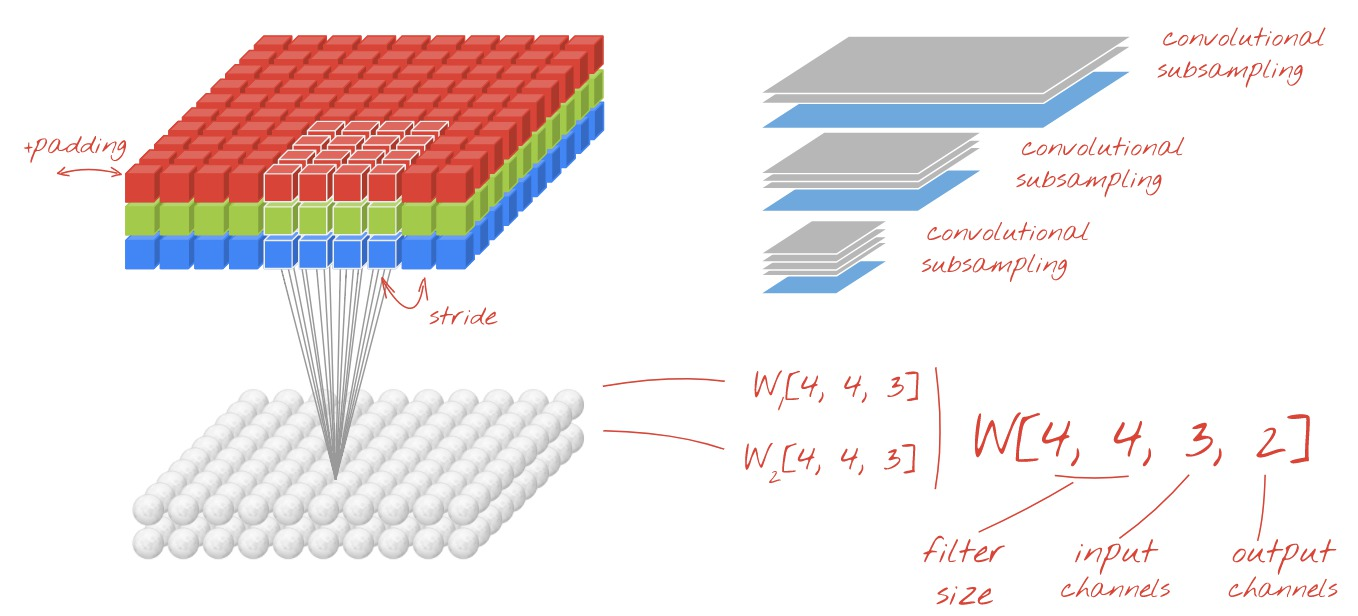

In [3]:
Image(filename='imgs/conv1.jpg', width=800)

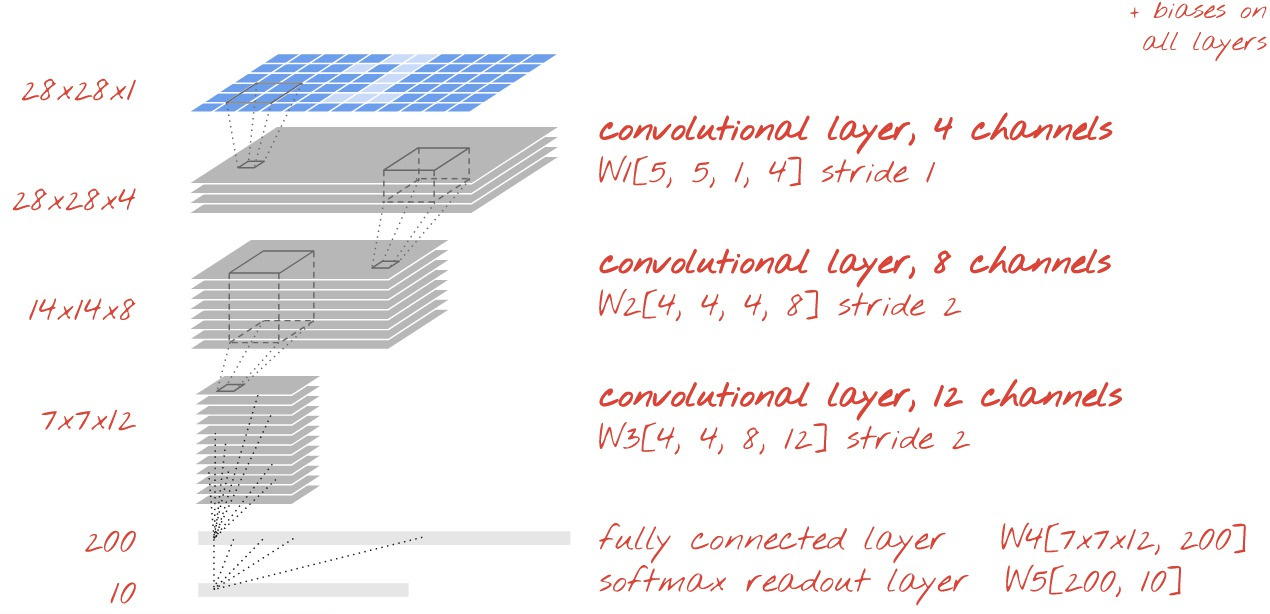

In [4]:
Image(filename='imgs/conv2.jpg', width=800)

## network implemented in this notes

| layer   | input_size  | output_size | filter_size  | stride | n_filters |activation| W_size from previous |
| ------- |:-----------:|:-----------:|:------------:|:------:|:---------:|:--------:|:--------------:|
| conv1   | 28x28x1     | 28x28x9     | 5x5          |1       | 16         | relu     | W1 = [5,5,1,16] |
| conv2   | 28x28x16    | 14x14x8    | 5x5          |2       | 8        | relu     | W2 = [5,5,16,8]|
| conv3   | 14x14x8     | 7x7x12    | 4x4          |2       | 12        | relu     | W2 = [4,4,8,12]|
| fc      | 7x7x12    |    200      |              |        |           | relu     | W3 = [588,200]|
| output  | 200         |   10        |              |        |           | softmax  | W4 = [200,10]|


## load MNIST data

In [3]:
from tensorflow.examples.tutorials.mnist import input_data
mnist = input_data.read_data_sets("/tmp/MNIST_data/", one_hot=True, reshape=False, validation_size=0)
print "free mem", humanbytes(psutil.virtual_memory().free)

Successfully downloaded train-images-idx3-ubyte.gz 9912422 bytes.
Extracting /tmp/MNIST_data/train-images-idx3-ubyte.gz
Successfully downloaded train-labels-idx1-ubyte.gz 28881 bytes.
Extracting /tmp/MNIST_data/train-labels-idx1-ubyte.gz
Successfully downloaded t10k-images-idx3-ubyte.gz 1648877 bytes.
Extracting /tmp/MNIST_data/t10k-images-idx3-ubyte.gz
Successfully downloaded t10k-labels-idx1-ubyte.gz 4542 bytes.
Extracting /tmp/MNIST_data/t10k-labels-idx1-ubyte.gz
free mem 798.97 MB


In [4]:
print mnist.train.images.shape
print mnist.test.images.shape

(60000, 28, 28, 1)
(10000, 28, 28, 1)


In [5]:
# number of images used for training and test
n=10000

idxs = np.random.permutation(range(len(mnist.train.images)))[:n]
train_imgs = mnist.train.images[idxs]
train_ohlabs = mnist.train.labels[idxs]
train_labels = np.r_[[np.argwhere(i)[0][0] for i in train_ohlabs]]

In [6]:
vn = n if n<mnist.test.images.shape[0] else mnist.test.images.shape[0]

idxs = np.random.permutation(range(len(mnist.test.images)))[:n]
test_imgs = mnist.test.images[idxs]
test_ohlabs = mnist.test.labels[idxs]
test_labels = np.r_[[np.argwhere(i)[0][0] for i in test_ohlabs]]

In [7]:
print train_imgs.shape, test_imgs.shape

(10000, 28, 28, 1) (10000, 28, 28, 1)


In [8]:
del(mnist)
gc.collect()
print "free mem", humanbytes(psutil.virtual_memory().free)

free mem 966.95 MB


In [9]:
print pd.Series(train_labels).value_counts()
print pd.Series(test_labels).value_counts()

1    1115
7    1092
3    1034
6    1021
0     996
2     972
8     966
9     963
5     923
4     918
dtype: int64
1    1135
2    1032
7    1028
3    1010
9    1009
4     982
0     980
8     974
6     958
5     892
dtype: int64


## create TF vars and graph

In [10]:
def get_TF_vars(K=16, L=8, M=12, N=200):

    tf.reset_default_graph()
    with tf.name_scope("data"):
        # input X: 28x28 grayscale images, the first dimension (None) will index the images in the mini-batch
        X = tf.placeholder(tf.float32, [None, 28, 28, 1])
        # correct answers will go here
        Y = tf.placeholder(tf.float32, [None, 10])
        # variable learning rate
        lr = tf.placeholder(tf.float32)
        lr = tf.constant(0.0005, tf.float32)

    with tf.name_scope("weights_biases"):
        W1 = tf.Variable(tf.truncated_normal([5, 5, 1, K], stddev=0.1), name="W1")  
        b1 = tf.Variable(tf.ones([K])/10, name="B1")
        W2 = tf.Variable(tf.truncated_normal([5, 5, K, L], stddev=0.1), name="W2")
        b2 = tf.Variable(tf.ones([L])/10, name="B2")
        W3 = tf.Variable(tf.truncated_normal([4, 4, L, M], stddev=0.1), name="W3")
        b3 = tf.Variable(tf.ones([M])/10, name="B3")

        W4 = tf.Variable(tf.truncated_normal([7 * 7 * M, N], stddev=0.1), name="W4")
        b4 = tf.Variable(tf.ones([N])/10, name="B4")
        W5 = tf.Variable(tf.truncated_normal([N, 10], stddev=0.1), name="W5")
        b5 = tf.Variable(tf.ones([10])/10, name="B5")
       
    return X,Y, lr, W1,b1, W2,b2, W3,b3, W4,b4, W5,b5

In [11]:
def get_TF_graph(tf_vars, pkeep=None):
        
    X,Y, lr, W1,b1, W2,b2, W3,b3, W4,b4, W5,b5 = tf_vars
    
    with tf.name_scope("layers"):
        stride = 1  # output is 28x28
        L1 = tf.nn.relu(tf.nn.conv2d(X, W1, strides=[1, stride, stride, 1], padding='SAME') + b1)

        stride = 2  # output is 14x14
        L2 = tf.nn.relu(tf.nn.conv2d(L1, W2, strides=[1, stride, stride, 1], padding='SAME') + b2)
            
        stride = 2  # output is 7x7
        L3 = tf.nn.relu(tf.nn.conv2d(L2, W3, strides=[1, stride, stride, 1], padding='SAME') + b3)

        # reshape the output from the third convolution for the fully connected layer
        L3r = tf.reshape(L3, shape=[-1, 7 * 7 * b3.shape.as_list()[0]])

        FC4 = tf.nn.relu(tf.matmul(L3r, W4) + b4)
        if pkeep is not None:
            FC4 = tf.nn.dropout(FC4, pkeep)
            
        logits = tf.matmul(FC4, W5) + b5
        y_hat = tf.nn.softmax(logits)    
    
    with tf.name_scope("loss"):
        cross_entropy = tf.nn.softmax_cross_entropy_with_logits(logits=logits, labels=Y)
        loss          = tf.reduce_mean(cross_entropy)*100

    with tf.name_scope("accuracy"):
        correct_pred = tf.equal(tf.argmax(y_hat, 1), tf.argmax(Y, 1))
        accuracy = tf.reduce_mean(tf.cast(correct_pred, tf.float32))

    with tf.name_scope("optimizer"):
        train_step = tf.train.AdamOptimizer(lr).minimize(loss)
    
    return L1, FC4,  y_hat, loss, train_step, accuracy

## optimization loop

observe **test accuracy is measured with a sample** which trainig and in batches when finished for memory reasons

In [12]:
def fit (X_train, y_train, X_test, y_test, 
         model_name, loss, train_step, accuracy, 
         batch_size, n_epochs, log_freq):
    
    X,Y, lr, W1,b1, W2,b2, W3,b3, W4,b4, W5,b5 = tf_vars
    saver = tf.train.Saver()
    
    tf.summary.histogram("W1", W1)
    tf.summary.histogram("b1", b1)
    tf.summary.histogram("W2", W2)
    tf.summary.histogram("b2", b2)
    tf.summary.histogram("W3", W3)
    tf.summary.histogram("b3", b3)
    tf.summary.histogram("W4", W4)
    tf.summary.histogram("b4", b4)
    tf.summary.histogram("W5", W5)
    tf.summary.histogram("b5", b5)

    summary_merged = tf.summary.merge_all()
    summary_train_accuracy = tf.summary.scalar("train_accuracy", accuracy)
    summary_test_accuracy   = tf.summary.scalar("test_accuracy", accuracy)

    summary_train_loss = tf.summary.scalar("train_loss", loss)
    summary_test_loss   = tf.summary.scalar("test_loss", loss)    
    
    # Initialize the variables (i.e. assign their default value)
    init = tf.global_variables_initializer()
    log_train, log_test = [], []

    # Start training
    from rlx.ml import Batches
    from time import time

    with tf.Session() as sess:
        from datetime import datetime

        model_name = model_name + "_" + datetime.now().strftime("%Y-%m-%d_%H:%M")
        log_name   = "log/"+model_name
        print "logging to ", log_name
        summary_writer = tf.summary.FileWriter(log_name,sess.graph)
        
        sess.run(init)

        step = 1
        t1 = time()
        for epoch in range(1,n_epochs+1):
            ndata = 0
            for batch_X, batch_y in Batches([X_train, y_train], batch_size=batch_size, n_epochs=1, shuffle=True).get():
                ndata += len(batch_X)
                # Run optimization 
                summ_acc, summ_loss, train_acc, _ = sess.run([summary_train_accuracy, summary_train_loss,
                                                              accuracy, train_step], 
                                                              feed_dict={X: batch_X, Y: batch_y})
                summary_writer.add_summary(summ_acc, step)
                summary_writer.add_summary(summ_loss, step)
                t2 = time()
                log_train.append([step, t2-t1, train_acc])
                print "\repoch %3d/%d step %5d: train acc: %.4f, time: %.3f segs, %7d/%d"%\
                      (epoch, n_epochs, step, train_acc, (t2-t1), ndata, len(train_imgs)),    

                if step%log_freq==0:
                    idxs = np.random.permutation(range(len(X_test)))[:1000]                    
                    test_acc = sess.run(accuracy, feed_dict = {X: X_test[idxs], Y: y_test[idxs]})

                    print "\repoch %3d/%d step %5d: train acc: %.4f, test acc: %.4f, time: %.3f segs, %d data items"%\
                          (epoch, n_epochs, step, train_acc, test_acc, (t2-t1), ndata)     

                    log_test.append([step, t2-t1, test_acc])
                    summ_merged, summ_test_acc = sess.run([summary_merged, summary_test_accuracy], 
                                                          feed_dict = {X: X_test[idxs], Y: y_test[idxs]})  
                    summary_writer.add_summary(summ_merged, step)
                    summary_writer.add_summary(summ_test_acc, step)
                    saver.save(sess, "models/"+model_name+".tf")

                step += 1

        print("Optimization Finished!")

        # Calculate accuracy for test images by batches (for low memory)
        test_acc = 0
        for batch_X, batch_y in Batches([X_test, y_test], batch_size=batch_size, n_epochs=1).get():
            test_acc += sess.run(accuracy, feed_dict={X: batch_X, Y: batch_y})*len(batch_X)/len(X_test)
            
        print("Testing Accuracy:", test_acc)

        saver.save(sess, "models/"+model_name+".tf")
        log_train = pd.DataFrame(log_train, columns=["step", "time", "accuracy"])
        log_test  = pd.DataFrame(log_test, columns=["step", "time", "accuracy"])
    return log_train, log_test, model_name

def plot_results(log_train, log_test):
    k = log_train.rolling(window=10).mean().dropna()
    plt.plot(k.time, k.accuracy, color="blue", lw=2, label="train")
    plt.plot(log_test.time, log_test.accuracy, color="red",lw=2, label="test")
    plt.legend(loc="center left", bbox_to_anchor=(1,.5))
    plt.plot(log_train.time, log_train.accuracy, alpha=.3, color="blue")
    plt.grid()
    plt.xlabel("elapsed time (secs)")
    plt.ylabel("accuracy")
    plt.axhline(0.5, color="black")
    plt.ylim(0.8,1.)
    plt.xlim(0,log_train.time.max()+1)
    plt.title("final train_acc=%.4f, test_acc=%.4f"%(log_train.accuracy.values[-1], log_test.accuracy.values[-1]))

In [13]:
tf_vars = get_TF_vars()
L1, FC4, y_hat, loss, train_step, accuracy = get_TF_graph(tf_vars, pkeep=.75)
print "free mem", humanbytes(psutil.virtual_memory().free)

free mem 963.16 MB


/opt/miniconda/lib/python2.7/site-packages/statsmodels/compat/pandas.py:56: FutureWarning: The pandas.core.datetools module is deprecated and will be removed in a future version. Please use the pandas.tseries module instead.
  from pandas.core import datetools


logging to  log/cnn_mnist_2018-01-13_19:10
epoch   1/10 step   100: train acc: 0.8600, test acc: 0.8590, time: 13.160 segs, 10000 data items                          
epoch   2/10 step   200: train acc: 0.9600, test acc: 0.9060, time: 36.441 segs, 10000 data items                                           
epoch   3/10 step   300: train acc: 0.9100, test acc: 0.9310, time: 54.875 segs, 10000 data items                                   
epoch   4/10 step   400: train acc: 0.9700, test acc: 0.9350, time: 71.619 segs, 10000 data items                                 
epoch   5/10 step   500: train acc: 0.9200, test acc: 0.9410, time: 85.686 segs, 10000 data items                              
epoch   6/10 step   600: train acc: 0.9800, test acc: 0.9560, time: 101.779 segs, 10000 data items                                
epoch   7/10 step   700: train acc: 0.9600, test acc: 0.9550, time: 117.027 segs, 10000 data items                                  
epoch   8/10 step   800: train acc: 

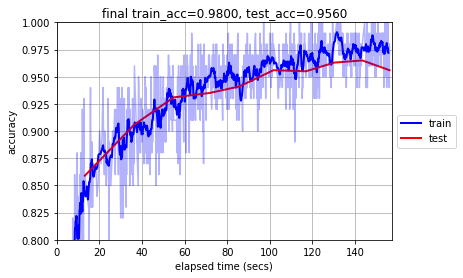

In [14]:
log_train, log_test, model_name = fit(train_imgs, train_ohlabs, test_imgs, test_ohlabs,
                         "cnn_mnist", loss, train_step, accuracy,
                         batch_size=100, n_epochs=10, log_freq=100)

plot_results(log_train, log_test)
print "free mem", humanbytes(psutil.virtual_memory().free)

In [15]:
X,Y, lr, W1,b1, W2,b2, W3,b3, W4,b4, W5,b5 = tf_vars

In [16]:
import tflearn

In [17]:
idxs = np.random.permutation(range(len(test_imgs)))[:1000]                    
sample_test_imgs = test_imgs[idxs]
sample_test_labels = test_labels[idxs]
sample_test_ohlabs = test_ohlabs[idxs]
with tf.Session() as sess:
    saver = tf.train.Saver()
    tflearn.config.init_training_mode()

    saver.restore(sess, "models/"+model_name+".tf")    
    L1_activations, FC4_activations, test_preds, w1,w2,w3,w4,w5 = sess.run([L1,FC4,y_hat,W1,W2,W3,W4,W5], 
                                                                           feed_dict={X:sample_test_imgs})
    

INFO:tensorflow:Restoring parameters from models/cnn_mnist_2018-01-13_19:10.tf


In [18]:
print test_preds.shape, sample_test_labels.shape
print np.mean(sample_test_labels==np.argmax(test_preds, axis=1))

(1000, 10) (1000,)
0.961


In [19]:
from rlx.ml import confusion_matrix
confusion_matrix(sample_test_labels, np.argmax(test_preds, axis=1))

predicted,0,1,2,3,4,5,6,7,8,9
true,,,,,,,,,,
0,100,0,0,0,0,0,0,1,0,0
1,0,102,0,0,0,0,0,0,0,0
2,0,0,110,2,0,0,1,1,1,0
3,0,0,0,97,0,1,0,1,2,3
4,0,0,0,0,90,0,1,1,1,3
5,0,0,0,1,0,83,0,0,1,0
6,2,1,0,0,1,0,93,0,1,0
7,0,2,1,1,0,0,0,100,0,1
8,1,1,0,2,0,0,0,0,78,1


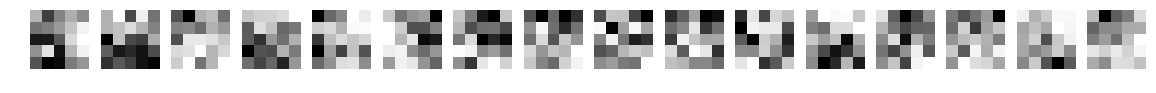

In [20]:
def display_filters(w):
    plt.figure(figsize=(20,3))
    for i in range(w.shape[-1]):
        plt.subplot(1,w.shape[-1],i+1)
        plt.imshow(w[:,:,i], cmap = plt.cm.Greys_r, interpolation="none")
        plt.axis("off")
        
display_filters(w1[:,:,0,:])

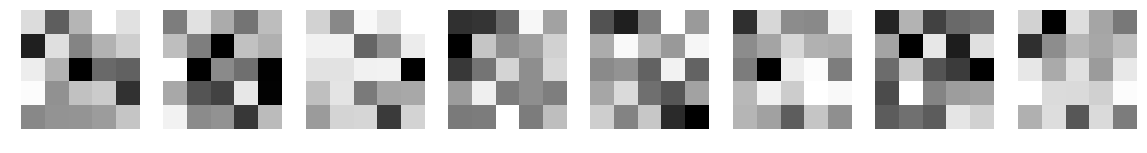

In [21]:
display_filters(w2[:,:,0,:])

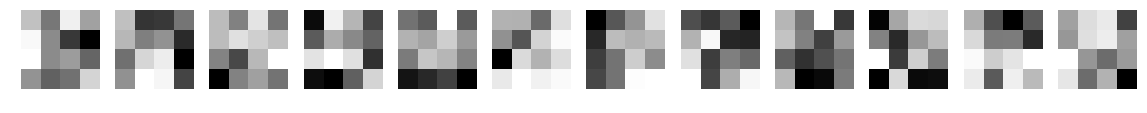

In [22]:
display_filters(w3[:,:,0,:])

### show some misses

In [23]:
preds  = np.argmax(test_preds, axis=1)
misses = np.argwhere(sample_test_labels != preds)[:,0]

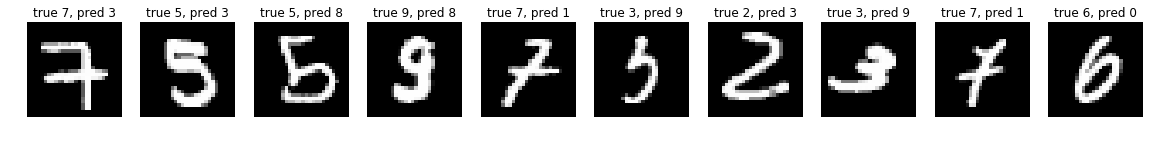

In [24]:
idxs = np.random.permutation(misses)[:10]
plt.figure(figsize=(20,3))
for i,idx in enumerate(idxs):
    plt.subplot(1,10,i+1)
    plt.imshow(sample_test_imgs[idx][:,:,0], cmap=plt.cm.Greys_r)
    plt.axis("off")
    plt.title("true %d, pred %d"%(sample_test_labels[idx], preds[idx]))

observe how we select test imgs which predictions with greatest incertitude 

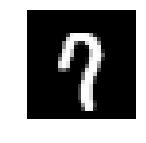

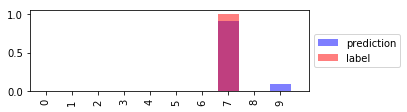

In [42]:
i = np.argsort(test_preds.max(axis=1))[:100][np.random.randint(100)]
img = sample_test_imgs[i][:,:,0]
plt.figure(figsize=(2,2))
plt.imshow(img, cmap=plt.cm.Greys_r)
plt.axis("off")
plt.figure(figsize=(5,1.5))
plt.bar(np.arange(10), test_preds[i], color="blue", alpha=.5, label="prediction")
plt.bar(np.arange(10), sample_test_ohlabs[i], color="red", alpha=.5, label="label")
plt.xticks(range(10), range(10), rotation="vertical");
plt.legend(loc="center left", bbox_to_anchor=(1,.5))
plt.xlim(-.6,10.1);

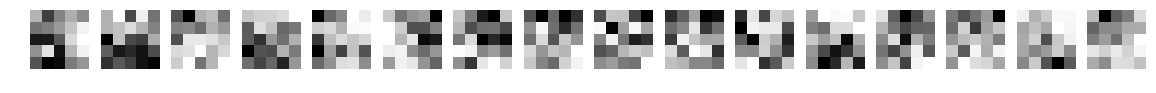

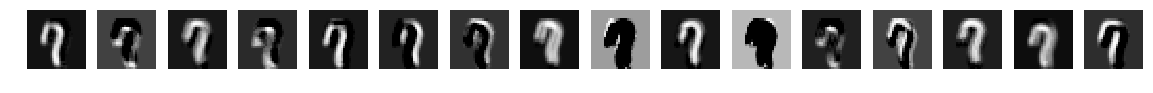

In [43]:
display_filters(w1[:,:,0,:])
display_filters(L1_activations[i])

average activations in FC


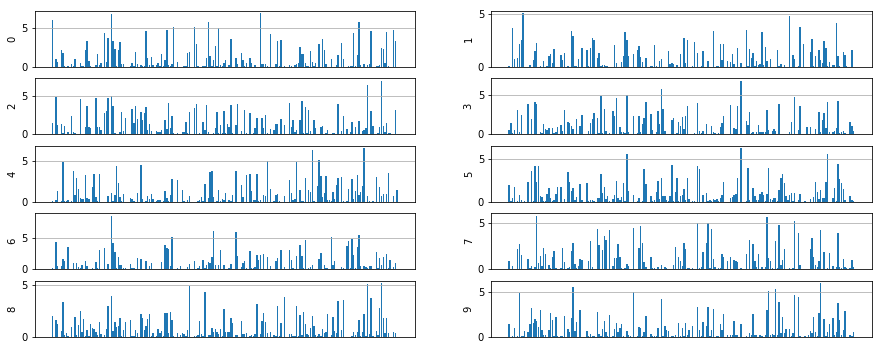

In [44]:
plt.figure(figsize=(15,6))
for i in np.unique(sample_test_labels):
    k = FC4_activations[sample_test_labels==i].mean(axis=0)
    plt.subplot(5,2,i+1)
    plt.bar(range(len(k)), k)
    plt.xticks([])
    plt.grid()
    plt.ylabel("%d"%i)
print "average activations in FC"